## Geocoding
### Overview of Geocoders
Geocoding is the process of transforming place names or addresses into coordinates. In this lesson we will learn how to geocode addresses using Geopandas and geopy.

Geopy and other geocoding libaries (such as geocoder) make it easy to locate the coordinates of addresses, cities, countries, and landmarks across the globe using web services (“geocoders”). In practice, geocoders are often Application Programming Interfaces (APIs) where you can send requests, and receive responses in the form of place names, addresses and coordinates.

Geopy offers access to several geocoding services, including:
- ESRI ArcGIS

- Baidu Maps

- Bing

- GeocodeFarm

- GeoNames

- Google Geocoding API (V3)

- HERE

- IGN France

- Mapquest

- OpenCage

- OpenMapQuest

- Open Street Map Nominatim

- What3words

- Yandex

Check the geopy documentation for more details about how to use each service via Python.

As you see, there are plenty of geocoders where to choose from! The quality of the geocoders might differ depending on the underlying data. For example, some addresses might exists on OpenStreetMap, but not on Google Maps and thus they can be geocoded using the Nominatim geocoder, but not using the Google Geocoding API - and vice versa.

Geocoding services might require an API key in order to use them. (i.e. you need to register for the service before you can access results from their API). Furthermore, rate limiting also restrict the use of these services. The geocoding process might end up in an error if you are making too many requests in a short time period (eg. trying to geocode large number of addresses). See hints for dealing with rate limiting when geocoding pandas DataFrames from the geopy documentation. If you pay for the geocoding service, you can naturally make more requests to the API.

In this lesson we will use the Nominatim geocoder for locating a relatively small number of addresses. Usage of the Nominatim geocoding service is rate-limited to 1 request per second (3600 / hour). You can read more about Nominatim usage policy in here

Luckily, Nominatim, which is a geocoder based on OpenStreetMap data does not require a API key to use their service if it is used to geocode only a small number of addresses.

### Geocoding in Geopandas
It is possible to do geocoding in Geopandas through geopy. Geopandas has a function called geocode() that can geocode a list of addresses (strings) and return a GeoDataFrame containing the resulting point objects in geometry column.

Let’s try this out.

We will geocode addresses stored in a text file called addresses.txt. These addresses are located in the Helsinki Region in Southern Finland.

The first rows of the data look like this:

In [1]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Filepath
fp = r"data/addresses.txt"

# Read the data
data = pd.read_csv(fp, sep=';')

In [2]:
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


### Geocode addresses using Nominatim
Now we have our data in a pandas DataFrame and we can geocode our addresses using the geopandas geocoding function that uses geopy package in the background.

- Let’s import the geocoding function and geocode the addresses (column addr) using Nominatim.

- Remember to provide a custom string (name of your application) in the user_agent parameter.

- If needed, you can add the timeout-parameter which specifies how many seconds we will wait for a response from the service.

In [3]:
# Import the geocoding tool
from geopandas.tools import geocode

# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_AB', timeout=4)

In [4]:
geo.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi..."
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,..."
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S..."
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län..."


And Voilà! As a result we have a GeoDataFrame that contains our original address and a ‘geometry’ column containing Shapely Point -objects that we can use for exporting the addresses to a Shapefile for example. However, the id column is not there. Thus, we need to join the information from data into our new GeoDataFrame geo, thus making a Table Join.

#### Rate-limiting

When geocoding a large dataframe, you might encounter an error when geocoding. In case you get a time out error, try first using the timeout parameter as we did above (allow the service a bit more time to respond). In case of Too Many Requests error, you have hit the rate-limit of the service, and you should slow down your requests. To our convenience, geopy provides additional tools for taking into account rate limits in geocoding services. This script adapts the usage of geopy RateLimiter to our input data.
All in all, remember that Nominatim is not meant for super heavy use.

### Table join

Joining data between two or several tables is a common task in many (spatial) data analysis workflows. As you might remember from our earlier lessons, combining data from different tables based on common key attribute can be done easily in pandas/geopandas using the merge() -function. We used this approach in the geo-python course exercise 6.

However, sometimes it is useful to join two tables together based on the index of those DataFrames. In such case, we assume that there is same number of records in our DataFrames and that the order of the records should be the same in both DataFrames.

We can use this approach to join information from the original data to our geocoded addresses row-by-row join() -function which merges the two DataFrames together based on index by default. This approach works correctly because the order of the geocoded addresses in geo DataFrame is the same as in our original data DataFrame.

In [5]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


As a result we have a new GeoDataFrame called join where we now have all original columns plus a new column for geometry. Note! If you would do the join the other way around, i.e. data.join(geo), the output would be a pandas DataFrame, not a GeoDataFrame!

Now it is easy to save our address points into a Shapefile

In [6]:
# Output file path
outfp = r"data/addresses.shp"

# Save to Shapefile
join.to_file(outfp)

### Notes about Nominatim
Nominatim works relatively nicely if you have well defined and well-known addresses such as the ones that we used in this tutorial. In practice, the address needs to exist in the OpenStreetMap database. Sometimes, however, you might want to geocode a “point-of-interest”, such as a museum, only based on it’s name. If the museum name is not on OpenStreetMap, Nominatim won’t provide any results for it, but you might be able to geocode the place using some other geocoder such as the Google Geocoding API (V3), which requires an API key. Take a look from past year’s materials where we show how to use Google Geocoding API in a similar manner as we used Nominatim here.

## Point in Polygon & Intersect
Finding out if a certain point is located inside or outside of an area, or finding out if a line intersects with another line or polygon are fundamental geospatial operations that are often used e.g. to select data based on location. Such spatial queries are one of the typical first steps of the workflow when doing spatial analysis. Performing a spatial join (will be introduced later) between two spatial datasets is one of the most typical applications where Point in Polygon (PIP) query is used.

For further reading about PIP and other geometric operations, see Chapter 4.2 in Smith, Goodchild & Longley: Geospatial Analysis - 6th edition.

### How to check if point is inside a polygon?
Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called Ray Casting algorithm. Luckily, we do not need to create such a function ourselves for conducting the Point in Polygon (PIP) query. Instead, we can take advantage of Shapely’s binary predicates that can evaluate the topolocical relationships between geographical objects, such as the PIP as we’re interested here.

There are basically two ways of conducting PIP in Shapely:

1. using a function called within() that checks if a point is within a polygon

2. using a function called contains() that checks if a polygon contains a point

Notice: even though we are talking here about Point in Polygon operation, it is also possible to check if a LineString or Polygon is inside another Polygon.

Let’s import shapely functionalities and create some points:

In [1]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Let’s also create a polygon using a list of coordinate-tuples:

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

# Let’s check if those points are within the polygon:

# Check if p1 is within the polygon using the within function
print(p1.within(poly))

# Check if p2 is within the polygon
print(p2.within(poly))

True
False


Okey, so we can see that the first point seems to be inside that polygon and the other one isn’t.
- In fact, the first point is quite close to close to the center of the polygon as we can see if we compare the point location to the polygon centroid:

In [2]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

# It is also possible to do PIP other way around, i.e. to check if polygon contains a point:

print(poly.contains(p1))
print(poly.contains(p2))

POINT (24.952242 60.1696017)
POINT (24.952242428492358 60.16960179038188)
True
False


Thus, both ways of checking the spatial relationship are identical; contains() is inverse to within() and vice versa.

Which one should you use then? Well, it depends:

- if you have many points and just one polygon and you try to find out which one of them is inside the polygon: You might need to iterate over the points and check one at a time if it is within() the polygon.

- if you have many polygons and just one point and you want to find out which polygon contains the point: You might need to iterate over the polygons until you find a polygon that contains() the point specified (assuming there are no overlapping polygons)

### Intersect
Another typical geospatial operation is to see if a geometry intersects or touches another one. Again, there are binary operations in Shapely for checking these spatial relationships:

- intersects(): Two objects intersect if the boundary or interior of one object intersect in any way with the boundary or interior of the other object.

- touches(): Two objects touch if the objects have at least one point in common and their interiors do not intersect with any part of the other object.

Let’s try these out.

Let’s create two LineStrings:

In [3]:
from shapely.geometry import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

print(line_a.intersects(line_b))
print(line_a.touches(line_b))

True
True


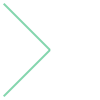

In [4]:
# Create a MultiLineString from line_a and line_b
multi_line = MultiLineString([line_a, line_b])
multi_line

Thus, the line_b continues from the same node ( (1,1) ) where line_a ends.

However, if the lines overlap fully, they don’t touch due to the spatial relationship rule, as we can see:

Check if line_a touches itself:

In [5]:
# Does the line touch with itself?
print(line_a.touches(line_a))

# Does the line intersect with itself?
print(line_a.intersects(line_a))

False
True


### Point in Polygon using Geopandas
Next we will do a practical example where we check which of the addresses from the geocoding tutorial are located in Southern district of Helsinki. Let’s start by reading a KML-file PKS_suuralue.kml that has the Polygons for districts of Helsinki Region (data openly available from Helsinki Region Infoshare.

Let’s start by reading the addresses from the Shapefile that we saved earlier.

In [6]:
import geopandas as gpd

fp = "data/addresses.shp"
data = gpd.read_file(fp)

data.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


### Reading KML-files in Geopandas
It is possible to read the data from KML-files with GeoPandas in a similar manner as Shapefiles. However, we need to first, enable the KML-driver which is not enabled by default (because KML-files can contain unsupported data structures, nested folders etc., hence be careful when reading KML-files). Supported drivers are managed with fiona.supported_drivers, which is integrated in geopandas. Let’s first check which formats are currently supported:

In [7]:
import geopandas as gpd
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

Let’s enable the read and write functionalities for KML-driver by passing 'rw' to whitelist of fiona’s supported drivers:

In [9]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r',
 'KML': 'rw'}

Now we should be able to read a KML file using the geopandas read_file() function.

Let’s read district polygons from a KML -file that is located in the data-folder:

In [10]:
# Filepath to KML file
fp = "data/PKS_suuralue.kml"
polys = gpd.read_file(fp, driver='KML')

In [11]:
#Check the data
print(f"Number of rows: {len(polys)}")
polys.head(11)

Number of rows: 23


,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."
5,Kauniainen,,"POLYGON Z ((24.69075 60.21958 0.00000, 24.6924..."
6,Suur-Leppävaara,,"POLYGON Z ((24.79747 60.20827 0.00000, 24.7954..."
7,Suur-Tapiola,,"POLYGON Z ((24.84436 60.16598 0.00000, 24.8443..."
8,Myyrmäki,,"POLYGON Z ((24.82459 60.29025 0.00000, 24.8243..."
9,Kivistö,,"POLYGON Z ((24.94309 60.33845 0.00000, 24.9421..."


<AxesSubplot:>

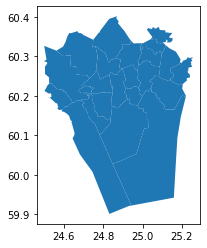

In [12]:
polys.plot()

We are interested in an area that is called Eteläinen (‘Southern’ in English).

Let’s select the Eteläinen district and see where it is located on a map:

In [22]:
# Select data 
southern = polys.loc[polys['Name']=='Eteläinen']

In [23]:
southern

,Name,Description,geometry
10,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


In [24]:
# Reset index for the selection
southern.reset_index(drop=True, inplace=True)

In [25]:
southern

,Name,Description,geometry
0,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


Let’s create a map which shows the location of the selected district, and let’s also plot the geocoded address points on top of the map:

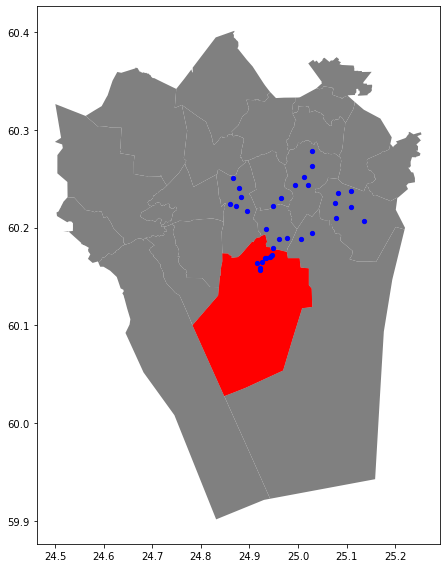

In [32]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
data.plot(ax=ax, color='blue', markersize=18)

plt.tight_layout()

Okey, so we can see that, indeed, certain points are within the selected red Polygon.

Let’s find out which one of them are located within the Polygon. Hence, we are conducting a Point in Polygon query.

First, let’s check that we have shapely.speedups enabled. This module makes some of the spatial queries running faster (starting from Shapely version 1.6.0 Shapely speedups are enabled by default):

In [34]:
#import shapely.speedups
from shapely import speedups
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

Let’s check which Points are within the southern Polygon. Notice, that here we check if the Points are within the geometry of the southern GeoDataFrame.

We use the .at[0, 'geometry'] to parse the actual Polygon geometry object from the GeoDataFrame.

In [40]:
pip_mask = data.within(southern.at[0,'geometry'])
print(pip_mask)

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool


As we can see, we now have an array of boolean values for each row, where the result is True if Point was inside the Polygon, and False if it was not.

We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is easy by passing the array inside the loc indexer:

In [41]:
pip_data = data.loc[pip_mask]
pip_data

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)
10,"Rautatientori, Kluuvi, Keskusta, Eteläinen suu...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.94410 60.17133)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93312 60.16909)
31,"Ruoholahdenkatu, Hietalahti, Kamppi, Eteläinen...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.92496 60.16497)
32,"Fitness online, 3, Tyynenmerenkatu, Jätkäsaari...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92119 60.15903)
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kluuvi, Kesku...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94709 60.17191)


Let’s finally confirm that our Point in Polygon query worked as it should by plotting the points that are within the southern district:

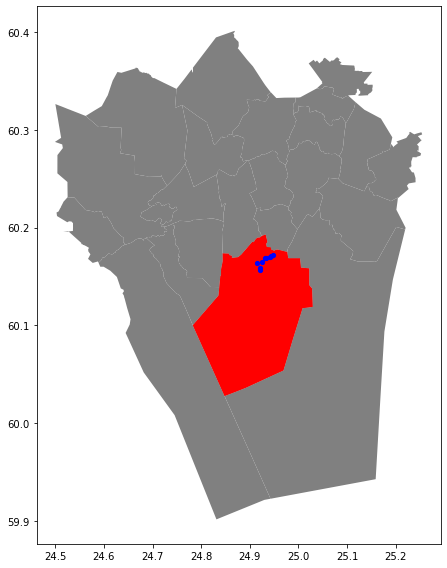

In [43]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
pip_data.plot(ax=ax, color='blue', markersize=18)

plt.tight_layout()

## Spatial join
Spatial join is yet another classic GIS problem. Getting attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis.

In the previous section we learned how to perform a Point in Polygon query. We can now use the same logic to conduct a spatial join between two layers based on their spatial relationship. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that contains the point.

Luckily, spatial join is already implemented in Geopandas, thus we do not need to create our own function for doing it. There are three possible types of join that can be applied in spatial join that are determined with op -parameter in the gpd.sjoin() -function:

- "intersects"

- "within"

- "contains"

Sounds familiar? Yep, all of those spatial relationships were discussed in the Point in Polygon lesson, thus you should know how they work.

Furthermore, pay attention to the different options for the type of join via the how parameter; “left”, “right” and “inner”. You can read more about these options in the geopandas sjoin documentation and pandas guide for merge, join and concatenate

Let’s perform a spatial join between these two layers:

- Addresses: the geocoded address-point (we created this Shapefile in the geocoding tutorial)

- Population grid: 250m x 250m grid polygon layer that contains population information from the Helsinki Region.

    - The population grid a dataset is produced by the Helsinki Region Environmental Services Authority (HSY) (see this page to access data from different years).

    - You can download the data from from this link in the Helsinki Region Infroshare (HRI) open data portal.

- Here, we will access the data directly from the HSY wfs:

In [45]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

proxies = {
 "http": "http://10.1.10.99:8080",
 "https": "http://10.1.10.99:8080"
}

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params, proxies=proxies)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))


In [46]:
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,"POLYGON ((25472499.995 6689749.005, 25472499.9...",688,9,28.0,99,99,99,99,99,99,99,99,99
1,"POLYGON ((25472499.995 6685998.998, 25472499.9...",703,5,51.0,99,99,99,99,99,99,99,99,99
2,"POLYGON ((25472499.995 6684249.004, 25472499.9...",710,8,44.0,99,99,99,99,99,99,99,99,99
3,"POLYGON ((25472499.995 6683999.005, 25472499.9...",711,5,90.0,99,99,99,99,99,99,99,99,99
4,"POLYGON ((25472499.995 6682998.998, 25472499.9...",715,11,41.0,99,99,99,99,99,99,99,99,99


Okey so we have multiple columns in the dataset but the most important one here is the column asukkaita (“population” in Finnish) that tells the amount of inhabitants living under that polygon.

- Let’s change the name of that column into pop18 so that it is more intuitive. As you might remember, we can easily rename (Geo)DataFrame column names using the rename() function where we pass a dictionary of new column names like this: columns={'oldname': 'newname'}.

In [51]:
# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# Let’s also get rid of all unnecessary columns by selecting only columns that we need i.e. pop18 and geometry

# Subset columns
pop = pop[["pop18", "geometry"]]

pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


### Join the layers
Now we are ready to perform the spatial join between the two layers that we have. The aim here is to get information about **how many people live in a polygon that contains an individual address-point**. Thus, we want to join attributes from the population layer we just modified into the addresses point layer addresses.shp that we created trough gecoding in the previous section.

Read the addresses layer into memory:

In [53]:
# Addresses filpath
addr_fp = r"data/addresses.shp"

# Read data
addresses = gpd.read_file(addr_fp)

# Check the head of the file
addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In order to do a spatial join, the layers need to be in the same projection

Check the crs of input layers:

In [54]:
addresses.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [56]:
# If the crs information is missing from the population grid, we can define the coordinate reference system as ETRS GK-25 (EPSG:3879) because we know what it is based on the population grid metadata.

# Define crs
pop.crs = CRS.from_epsg(3879).to_wkt()

pop.crs

<Derived Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - nominally onshore between 24°30'E and 25°30'E but may be used in adjacent areas if a municipality chooses to use one zone over its whole extent.
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
# Are the layers in the same projection?
addresses.crs == pop.crs

False

In [58]:
# Let’s re-project addresses to the projection of the population layer:
addresses = addresses.to_crs(pop.crs)

In [59]:
# Check the crs of address points
print(addresses.crs)

# Check the crs of population layer
print(pop.crs)

# Do they match now?
addresses.crs == pop.crs

PROJCRS["ETRS89 / GK25FIN",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Finland Gauss-Kruger zone 25",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.

True

Now they should be identical. Thus, we can be sure that when doing spatial queries between layers the locations match and we get the right results e.g. from the spatial join that we are conducting here.

- Let’s now join the attributes from pop GeoDataFrame into addresses GeoDataFrame by using gpd.sjoin() -function:

In [60]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how="inner", op="within")

C:\Users\alfoldybalint\.conda\envs\python_gis\lib\site-packages\IPython\core\interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [61]:
join.head()

,address,id,addr,geometry,index_right,pop18
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3252,515
1,"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496206.216 6672909.016),3364,182
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496768.622 6673002.004),3488,38
10,"Rautatientori, Kluuvi, Keskusta, Eteläinen suu...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (25496896.734 6673162.114),3488,38
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (25498769.713 6675121.127),3822,61


Awesome! Now we have performed a successful spatial join where we got two new columns into our join GeoDataFrame, i.e. index_right that tells the index of the matching polygon in the population grid and pop18 which is the population in the cell where the address-point is located.

Let’s still check how many rows of data we have now:

In [64]:
print(len(join))
print(len(addresses))

31
34


If we plot the layers on top of each other, we can observe that some of the points are located outside the populated grid squares (increase figure size if you can’t see this properly!)

<AxesSubplot:>

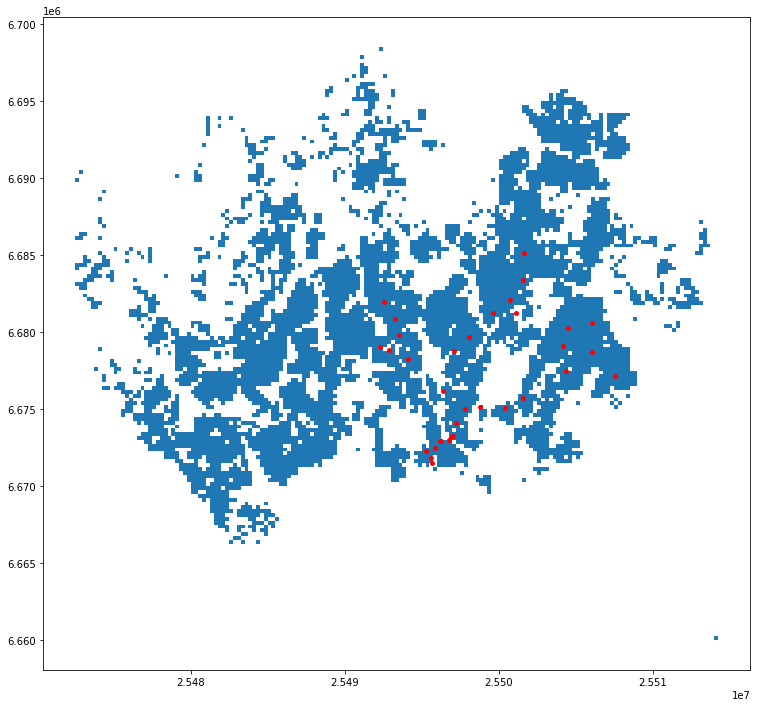

In [67]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,12))

# Plot population grid
pop.plot(ax=ax)

# Plot points
addresses.plot(ax=ax, color='red', markersize=15)

Let’s also visualize the joined output:

Plot the points and use the pop18 column to indicate the color. cmap -parameter tells to use a sequential colormap for the values, markersize adjusts the size of a point, scheme parameter can be used to adjust the classification method based on pysal, and legend tells that we want to have a legend:

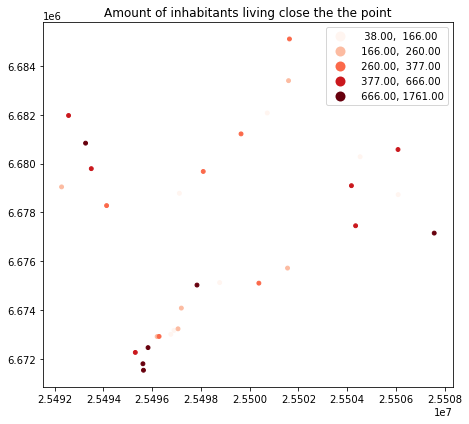

In [70]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the points with population info
join.plot(ax=ax, column='pop18', cmap="Reds", markersize=15, scheme='quantiles', legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

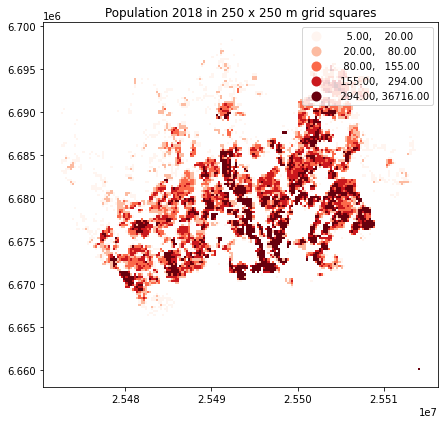

In [72]:
# In a similar way, we can plot the original population grid and check the overall population distribution in Helsinki:

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the grid with population info
pop.plot(ax=ax, column='pop18', cmap="Reds", scheme='quantiles', legend=True);

# Add title
plt.title("Population 2018 in 250 x 250 m grid squares");

# Remove white space around the figure
plt.tight_layout()

In [73]:
# Output path
outfp = r"data/addresses_population.shp"

# Save to disk
join.to_file(outfp)

C:\Users\alfoldybalint\AppData\Local\Temp\ipykernel_11580\218676674.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  join.to_file(outfp)
